In [1]:
from functions import *

In [33]:
n = 5
T = 0.1

In [34]:
def plot_ra_schedule(ramp_up_schedule):
    schedule = np.concatenate((ramp_up_schedule, ramp_up_schedule[::-1][1:]))
    n_points = len(schedule)
    plt.plot(np.linspace(0,1,n_points), schedule, '.--', color = red)
    plt.xlabel('s')
    plt.ylabel('$\gamma(s)$')
    plt.title('$H(\gamma) = \gamma H_{prob} + (1-\gamma) H_{mix}$')
    plt.show()

In [35]:
def get_proposal_mat_ra(m, ramp_up_schedule, t_max):
    H_ising = np.diag(m.E_rescaled)
    H_mixer = H_mixer_list[m.n-1]
    d = int(2**m.n)

    def s(t): return t/t_max

    def f(s, ramp_up_schedule):
        schedule = np.concatenate([ramp_up_schedule, ramp_up_schedule[::-1][1:]])
        n_points = len(schedule)
        times = np.linspace(0, 1, n_points)
        time_step = 1 / (n_points - 1)

        # Check if s is outside the range of the points
        if s < 0 or s > 1:
            raise ValueError("t is out of the bounds")

        # Find the correct interval for x
        for i in range(n_points - 1):
            if times[i] <= s <= times[i+1]:
                # Extract points (x0, y0) and (x1, y1)
                y0 = schedule[i]
                s0 = times[i]
                y1 = schedule[i + 1]
                # Linear interpolation formula
                return y0 + (y1 - y0) * (s - s0) / time_step

    def hamiltonian(t): return (1-f(s(t), ramp_up_schedule))*H_ising + f(s(t), ramp_up_schedule)*H_mixer

    def tdse_U(t, U): 
        return -1j*(hamiltonian(t)@U.reshape(d,d)).flatten()
    
    U0 = np.eye(d, dtype=complex).flatten()
    sol = solve_ivp(tdse_U, 
                    [0, t_max], 
                    y0=U0, 
                    rtol=1e-10, 
                    method='RK23')
    
    U_t = sol.y.T[-1].reshape(d,d)
    return np.abs(U_t)**2

In [36]:
def loss(ramp_up_schedule, t_max = 10):
    delta_avg = 0
    n_random_models = 10
    for seed in range(n_random_models):
        m = RandomIsingModel(n=n, seed=seed)
        proposal_mat_ra = get_proposal_mat_ra(m, ramp_up_schedule, t_max)
        P = get_transition_matrix(m, T, proposal_mat_ra)
        delta_avg += get_delta(P) / n_random_models
    return -delta_avg

Initial spectral gap =  0.0484


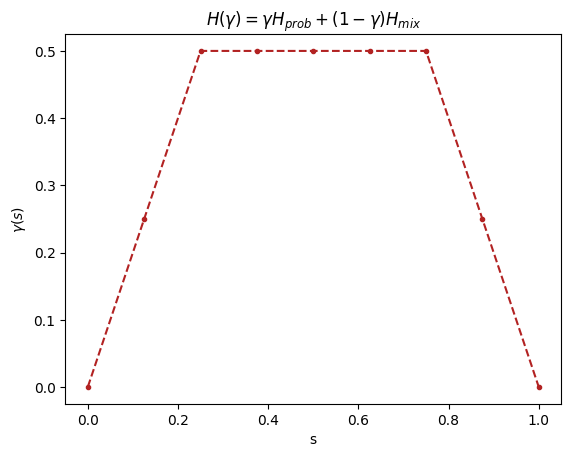

In [37]:
f_max = 0.5
t_max = 10
ramp_up_schedule_init = np.concatenate([np.linspace(0, f_max, 3), np.ones(2)*f_max])
schedule_init = np.concatenate([ramp_up_schedule_init, ramp_up_schedule_init[::-1][1:]])

loss_init = loss(ramp_up_schedule_init)
print('Initial spectral gap = ', -loss_init.round(4))
plot_ra_schedule(ramp_up_schedule_init)

In [38]:
m = RandomIsingModel(n=n, seed=0)
H_ising = np.diag(m.E_rescaled)
H_mixer = H_mixer_list[m.n-1]
d = int(2**m.n)

In [100]:
def s(t): return t/t_max

def f(s, ramp_up_schedule):
    schedule = np.concatenate([ramp_up_schedule, ramp_up_schedule[::-1][1:]])
    n_points = len(schedule)
    times = np.linspace(0, 1, n_points)
    time_step = 1 / (n_points - 1)

    # Check if s is outside the range of the points
    if s < 0 or s > 1:
        raise ValueError("t is out of the bounds")

    # Find the correct interval for x
    for i in range(n_points - 1):
        if times[i] <= s <= times[i+1]:
            # Extract points (x0, y0) and (x1, y1)
            y0 = schedule[i]
            s0 = times[i]
            y1 = schedule[i + 1]
            # Linear interpolation formula
            return y0 + (y1 - y0) * (s - s0) / time_step

ramp_up_schedule = ramp_up_schedule_init
schedule = np.concatenate([ramp_up_schedule, ramp_up_schedule[::-1][1:]])
n_points = len(schedule)
times = np.linspace(0,t_max,n_points)

def hamiltonian(s): 
    return (1-s)*H_ising + s*H_mixer

n_steps = len(schedule_init)
energies = np.zeros((n_steps, d))
eigenstates = np.zeros((n_steps, d, d), dtype=np.complex128)
for i, u in enumerate(schedule_init):
    w, v = np.linalg.eigh(hamiltonian(u))
    energies[i,:] = w
    eigenstates[i,:,:] = v

def tdse_psi(t, psi, hamiltonian, f): 
    return -1j * hamiltonian(f(s(t), ramp_up_schedule)) @ psi

psi_0 = eigenstates[0,15]

sol = solve_ivp(tdse_psi, 
                [0, t_max], 
                y0=psi_0, 
                t_eval=times,
                rtol=1e-10, 
                method='RK23',
                args=(hamiltonian,f)
                )

In [101]:
z_basis_probs = np.abs(sol.y.T)**2
eigstate_probs = np.zeros((n_points, d))
for u in range(n_points):
    amps = eigenstates[u].T.conj() @ sol.y.T[u]
    eigstate_probs[u] = np.abs(amps)**2

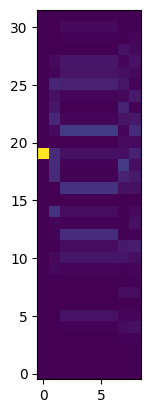

In [102]:
plt.imshow(eigstate_probs.T, origin='lower')
plt.show()

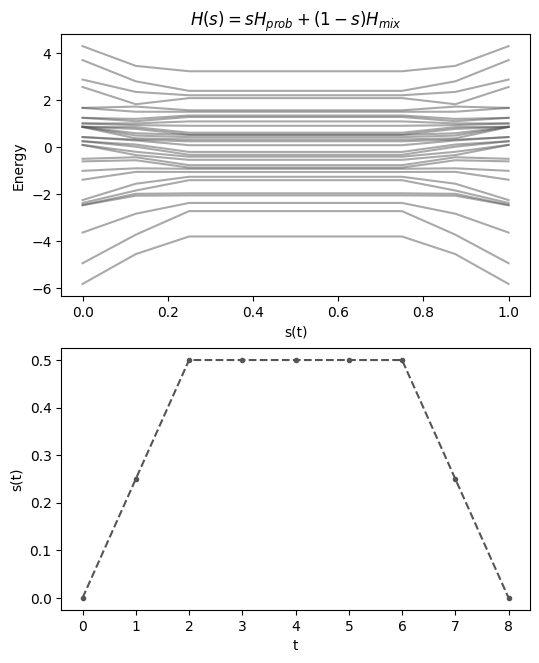

In [51]:
plt.figure(figsize=(figure_size_x, figure_size_y*2))
plt.subplot(211)
for state in range(d):
    plt.plot(np.linspace(0,1,n_steps), energies[:,state], color = dark_grey, alpha = 0.5)
plt.xlabel('s(t)')
plt.ylabel('Energy')
plt.title('$H(s) = s H_{prob} + (1-s) H_{mix}$')

plt.subplot(212)
plt.plot(schedule_init, '.--', color = dark_grey)
plt.xlabel('t')
plt.ylabel('s(t)')
plt.show()